In [3]:
from transformers import pipeline, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, GemmaForCausalLM
import torch
from datasets import Dataset
import os
from sklearn.metrics import classification_report
os.environ['TRANSFORMERS_CACHE'] = "/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

def model_init(peft_dir):
    model_name = "meta-llama/Llama-2-7b-chat-hf"
    #model_name = "mistralai/Mistral-7B-Instruct-v0.1"
    #model_name="google/gemma-7b-it"
    model = AutoModelForCausalLM.from_pretrained(
        model_name,  
        cache_dir="/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/",
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #model = PeftModel.from_pretrained(model, peft_dir)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id
    return model, tokenizer

In [4]:
model, tokenizer = model_init('')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
pipeline = pipeline(model=model, tokenizer=tokenizer, task="text-generation")

f"""
    <bos><start_of_turn>user
Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<end_of_turn>
<start_of_turn>model
Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.<end_of_turn>
<start_of_turn>user
sentence: {text}
<start_of_turn>model"""

In [34]:
def get_sentiment_llama(text):
    input = f"""<s>[INST] <<SYS>>
    Your task is to do sentiment analysis. You will be given sentences in African American English that is variation of english. Keeping that in mind, depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.
    <</SYS>>
    
    sentence: {text} [/INST]"""
    #print(input)
    
    sequences = pipeline(
        input,
        do_sample=True,
        max_new_tokens=3,
        return_full_text=False,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,

        
        )
    res = sequences[0]['generated_text'].strip().lower()
    #print(res)
    if(len(res)> 0 and res[-1] == '.'):
        return res[:-1]
    else:
        return res

In [35]:
import pandas as pd

original_dataset = pd.read_csv("Final-original-dataset.csv")
pred = []
for i in range(2000, 2100):
    sentiment = get_sentiment_llama(original_dataset['sentence'][i])
    pred.append(sentiment)
    print(f"{i} original sentiment: {original_dataset['sentiment'][i]} predicted sentiment: {sentiment}")
print(classification_report(original_dataset['sentiment'][2000:2100], pred))  

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


2000 original sentiment: negative predicted sentiment: positive
2001 original sentiment: negative predicted sentiment: negative
2002 original sentiment: negative predicted sentiment: negative
2003 original sentiment: positive predicted sentiment: positive
2004 original sentiment: negative predicted sentiment: negative
2005 original sentiment: negative predicted sentiment: negative
2006 original sentiment: positive predicted sentiment: positive
2007 original sentiment: negative predicted sentiment: negative
2008 original sentiment: positive predicted sentiment: positive
2009 original sentiment: negative predicted sentiment: negative
2010 original sentiment: positive predicted sentiment: positive
2011 original sentiment: positive predicted sentiment: positive
2012 original sentiment: positive predicted sentiment: positive
2013 original sentiment: positive predicted sentiment: positive
2014 original sentiment: negative predicted sentiment: negative
2015 original sentiment: negative predic

KeyboardInterrupt: 

* Gemma 7B Prompt: f"""<bos><start_of_turn>user
Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<end_of_turn>
<start_of_turn>model
Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.<end_of_turn>
<start_of_turn>user
sentence: {text}
<start_of_turn>model""" 

* Mistral 7B Prompt:f"""<s>[INST] <<SYS>> Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<</SYS>> 
[/INST] Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.</s>[INST] sentence: {text} [/INST]"""

* Llama 2 7B Prompt: f"""<s>[INST] Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only. [/INST] Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.</s>[INST] sentence: {text} [/INST]"""

In [28]:
def add_prompt_zero_shot(batch):
    batch['text'] = [ f"""<s>[INST] <<SYS>>
    Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.
    <</SYS>> [/INST] 
    Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.</s>[INST] sentence: {text} [/INST]"""   for text in batch['sentence']]
    return batch

In [36]:
def get_sentiment_llama_dataset(batch):
    # Assuming 'pipeline' is a batch-capable function for sentiment analysis
    sequences = pipeline(
        batch['text'],  # Pass the whole batch of texts
        do_sample=True,
        max_new_tokens=3,
        return_full_text=False,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id
    )

    predictions = []
    for sequence in sequences:
        res = sequence[0]['generated_text'].strip().lower()
        if(len(res)> 0 and res[-1] == '.'):
            predictions.append(res[:-1])
        else:
            predictions.append(res)
    batch['prediction'] = predictions
    return batch

In [37]:
import os
import pandas as pd
from datasets import load_dataset

directory_path = "./datasets/"

dataset_list = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        dataset = load_dataset('csv', data_files=file_path, split='all')
        dataset_list.append((dataset, filename.split('.')[0]))

In [38]:
org_dataset = load_dataset('csv', data_files='Final-original-dataset.csv', split='all')
dataset_list.insert(0, (org_dataset, 'orginal_dataset'))

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

Map:   0%|          | 0/2355 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

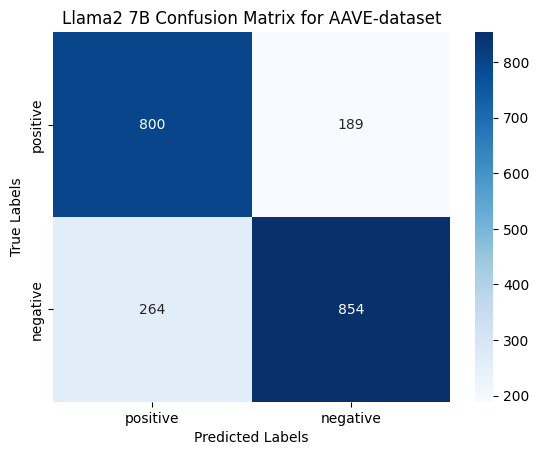

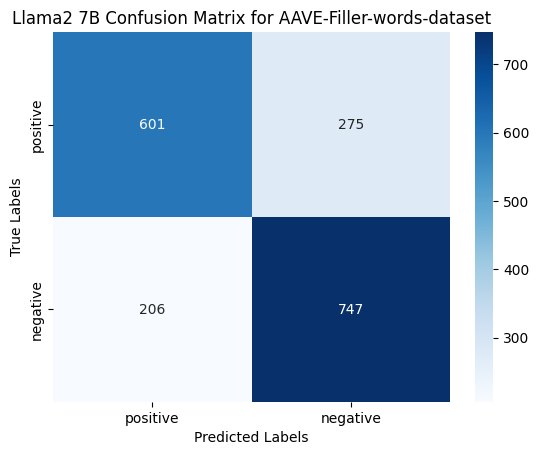

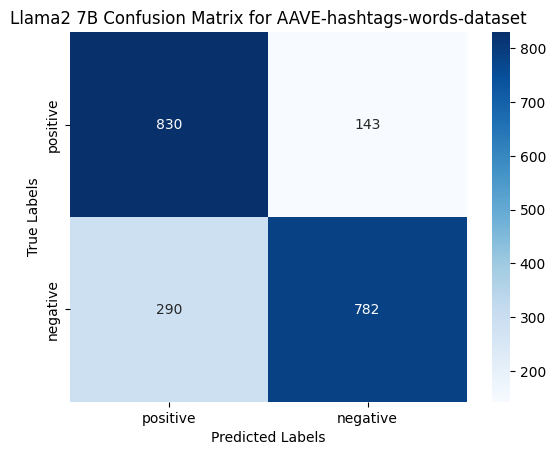

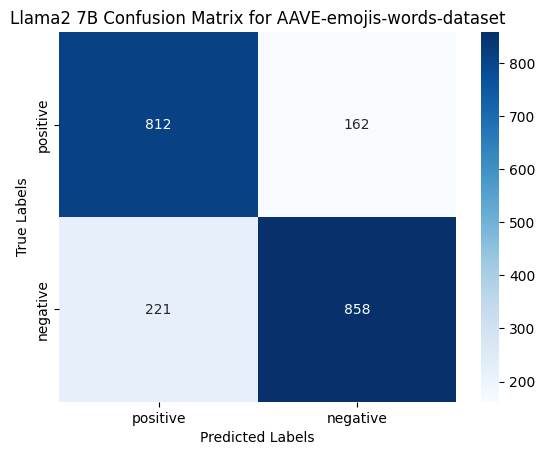

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
for dataset, name in dataset_list[1:]:
    dataset = dataset.map(add_prompt_zero_shot, batched=True)
    dataset = dataset.map(get_sentiment_llama_dataset, batched=True, batch_size=100)
    
    # Metrics. F1-score, accuracy, TPR and FPR
    metrics = classification_report(y_true=dataset['sentiment'],y_pred=dataset['prediction'], output_dict=True)
    cm = confusion_matrix(dataset['sentiment'], dataset['prediction'], labels=["positive", "negative"])
    dataframe = dataset.to_pandas() 
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    TNR = TN / (TN + FP)
    metrics['TPR'] = TPR
    metrics['FPR'] = FPR
    metrics['TNR'] = TNR
    metrics['FNR'] = FNR
    
    # Plotting the confusion matrix
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
    ax.set_title(f'Llama2 7B Confusion Matrix for {name.split("_cleaned")[0]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    
    report_json = json.dumps(metrics, indent=4)
    with open(f'./Llama2-results/{name}_classification_report.json', 'w') as file:
        file.write(report_json)
    dataframe.to_csv(f"Llama2-results/{name}.csv")
    plt.savefig(f"./Llama2-results/plots/{name}_CM_plot.png")

In [40]:
dataframe['prediction'].value_counts()

prediction
negative    1269
positive    1081
i cannot       3
sorry,         1
i apolog       1
Name: count, dtype: int64